# IF5200 - Modeling Notebook
___
Group: 8<br>
Project: Automated Chest X-Ray Report Generator in Bahasa Indonesia with the Use of Deep Learning<br>
Team members: Arief Purnama Muharram, Hollyana Puteri Haryono, Abassi Haji Juma

## A. Print library version

In [12]:
print('tqdm version:', __import__('tqdm').__version__)
print('matplotlib version:', __import__('matplotlib').__version__)
print('seaborn version:', __import__('seaborn').__version__)
print('pandas version:', __import__('pandas').__version__)
print('scikit-learn version:', __import__('sklearn').__version__)
print('pillow version:', __import__('PIL').__version__)
print('torch version:', __import__('torch').__version__)
print('torchvision version:', __import__('torchvision').__version__)

tqdm version: 4.64.1
matplotlib version: 3.5.3
seaborn version: 0.12.2
pandas version: 1.3.5
scikit-learn version: 1.0.2
pillow version: 9.4.0
torch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


## B. Load all helpers

In [13]:
from engine.utils.dataloader import CustomDataLoader
from engine.utils.train import TrainUtils

from engine.trainer import build_from_pretrained, train_wrapper

## C. Load dataset

In [14]:
import pandas as pd


df = pd.read_csv('datasets/labels_cxr-images.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Image Index         112120 non-null  object
 1   Filename_Segment1   112120 non-null  object
 2   Filename_Segment2   112120 non-null  object
 3   Filename_Segment3   112120 non-null  object
 4   Atelectasis         112120 non-null  int64 
 5   Cardiomegaly        112120 non-null  int64 
 6   Effusion            112120 non-null  int64 
 7   Infiltration        112120 non-null  int64 
 8   Mass                112120 non-null  int64 
 9   Nodule              112120 non-null  int64 
 10  Pneumonia           112120 non-null  int64 
 11  Pneumothorax        112120 non-null  int64 
 12  Consolidation       112120 non-null  int64 
 13  Edema               112120 non-null  int64 
 14  Emphysema           112120 non-null  int64 
 15  Fibrosis            112120 non-null  int64 
 16  Pl

In [15]:
df.head(3)

,Image Index,Filename_Segment1,Filename_Segment2,Filename_Segment3,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,00000001_000_segment1.png,00000001_000_segment2.png,00000001_000_segment3.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,00000001_001_segment1.png,00000001_001_segment2.png,00000001_001_segment3.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,00000001_002_segment1.png,00000001_002_segment2.png,00000001_002_segment3.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0


## D. Modeling

In [16]:
# Experiment global variables
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 64

### Example: Cardiomegaly

**Pretrain model:** ResNet50; **Image dimension:** 128x128; **Learning rate:** 1e-3; **Batch size:** 64; **Loss function:** CrossEntropyLoss; **Optimizer:** Adam

In [17]:
# Step 1: Create the dataset
# ---
# Please the columns name are 'filename' and 'label' only.
# 'filename' column describe the image filename only (e.g. '00000001_0001.png')
# 'label' column describe the label of the image (0 for absent and 1 for present)

from sklearn.model_selection import train_test_split


df_cardiomegaly = df[['Filename_Segment2', 'Cardiomegaly']]
df_cardiomegaly = df_cardiomegaly.rename(columns={'Filename_Segment2': 'filename', 'Cardiomegaly': 'label'}, errors='ignore')

train_dataset, test_dataset = train_test_split(
    df_cardiomegaly, test_size=0.3, random_state=0
)

train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.3, random_state=0
)

In [18]:
# Step 2: Create the dataloader

dataloader = CustomDataLoader(batch_size=BATCH_SIZE, image_path='datasets/data_cxr-images_128x128')

train_dataloader = dataloader.create_dataloader(train_dataset)
val_dataloader = dataloader.create_dataloader(val_dataset)
test_dataloader = dataloader.create_dataloader(test_dataset)

In [19]:
# Step 3: Build the model
# ---
# Current tested pretrained models: ResNet50

from torchvision.models import resnet50, ResNet50_Weights


model = build_from_pretrained(resnet50(weights=ResNet50_Weights.DEFAULT))

/home/jupyter-23521013/.local/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
# Step 4: Setup the trainer
# ---
# Supported loss function: CrossEntropyLoss
# Supported optimizer: SGD, Adam

from torch import device


trainer = TrainUtils(model, 'CrossEntropyLoss', 'Adam', learning_rate=LEARNING_RATE, device=device('cuda:3'))

Using GPU!
Device name: Quadro RTX 4000


Begin training!

Epoch 1 out of 3
 ------------


100%|██████████| 859/859 [03:07<00:00,  4.59it/s]


Training time: 187.24 seconds


100%|██████████| 368/368 [00:45<00:00,  8.08it/s]


Validation time: 45.54 seconds


100%|██████████| 526/526 [01:12<00:00,  7.21it/s]


Testing time: 72.92 seconds
Model models/model-resnet50_dim-128x128_loss-crossentropy_optim-adam_lr-1e-3_batch-64.pth stored!

Epoch 2 out of 3
 ------------


100%|██████████| 859/859 [03:08<00:00,  4.56it/s]


Training time: 188.46 seconds


100%|██████████| 368/368 [00:45<00:00,  8.00it/s]


Validation time: 45.99 seconds


100%|██████████| 526/526 [01:11<00:00,  7.37it/s]


Testing time: 71.34 seconds
Model models/model-resnet50_dim-128x128_loss-crossentropy_optim-adam_lr-1e-3_batch-64.pth stored!

Epoch 3 out of 3
 ------------


100%|██████████| 859/859 [03:04<00:00,  4.66it/s]


Training time: 184.41 seconds


100%|██████████| 368/368 [00:45<00:00,  8.13it/s]


Validation time: 45.24 seconds


100%|██████████| 526/526 [01:12<00:00,  7.23it/s]


Testing time: 72.79 seconds
Model models/model-resnet50_dim-128x128_loss-crossentropy_optim-adam_lr-1e-3_batch-64.pth stored!



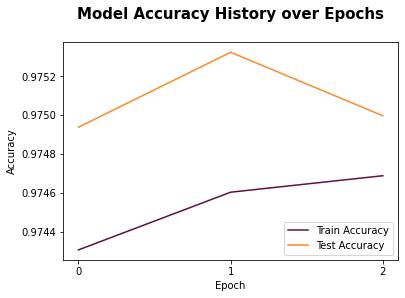

Train report:
Last train accuracy: 0.975
Last test accuracy: 0.975

Done!


In [21]:
# Step 5: Train the model using train_wrapper function

experiment_name = 'model-resnet50_dim-128x128_loss-crossentropy_optim-adam_lr-1e-3_batch-64'

train_wrapper(model, trainer,
              train_dataloader=train_dataloader,
              val_dataloader=val_dataloader,
              test_dataloader=test_dataloader,
              epochs=EPOCHS,
              saved_model_name=f'{experiment_name}.pth',
              log_name=f'{experiment_name}.txt')